In [1]:
import torch
import torch.nn
import torch.nn.functional as F
import torchvision.models as models
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
model = models.resnet34(pretrained=True, progress=True)
model.eval();
assert model.training == False

/home/kira/anaconda3/envs/leap-labs-exercise/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kira/anaconda3/envs/leap-labs-exercise/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
def image_to_tensor(img: Image.Image) -> torch.Tensor:
    transform = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    # Add the batch dimension
    # （C, H, W) --> (1, C, H, W)
    return transform(img).unsqueeze(0)

def tensor_to_image(tensor: torch.Tensor) -> Image.Image:
    transform = transforms.Compose(
        [
            # De-normalize
            transforms.Normalize(mean=[0, 0, 0], std=[1/0.229, 1/0.224, 1/0.225]),
            transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        ]
    )

    # Remove the batch dimension
    # (1, C, H, W) --> (C, H, W)
    image = transform(tensor.squeeze(0))
    image = image.clamp(0, 1)
    # (C, H, W) --> (H, W, C)
    image = image.permute(1, 2, 0)
    return image.detach().numpy()


def get_input_tensor(img_path: str) -> torch.Tensor:
    img = Image.open(img_path)
    # Applies normalization and scaling. Returns a tensor of shape (C, H, W)
    img_tensor = image_to_tensor(img)
    img_tensor.requires_grad = True
    return img_tensor

/tmp/ipykernel_32241/2810166396.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_adv_prev_step = torch.tensor(input.data, requires_grad=True)


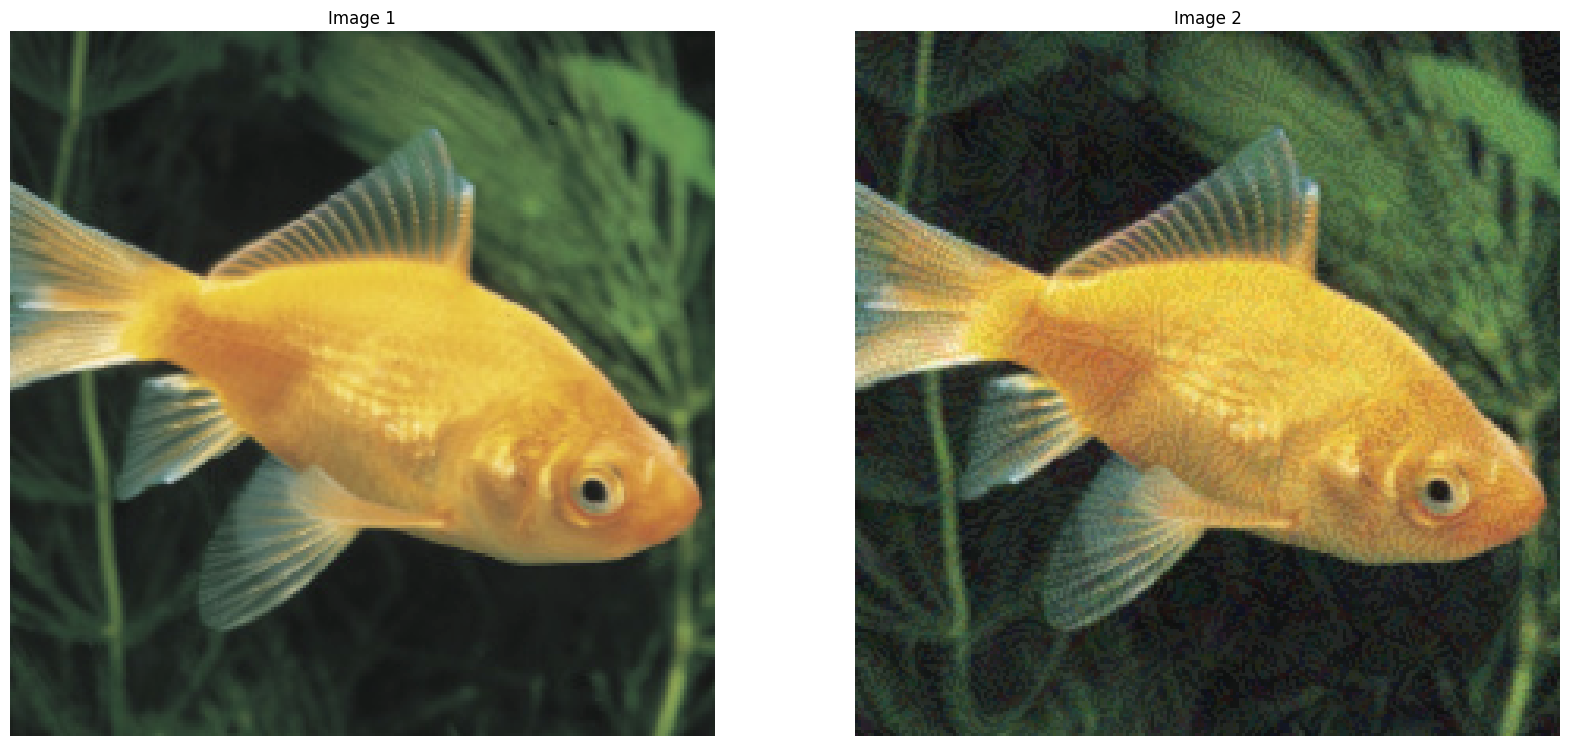

Desired target class: 893
Original image predicted class: 1
Adversarial image predicted class: 893
Original image predicted class probability: 0.991932213306427
Adversarial image predicted class probability: 0.8885440230369568


In [4]:
def generate_adversarial_example(model: torch.nn.Module, input: torch.Tensor, target_class: int, num_steps: int = 3, epsilon: float = 0.25, alpha: float = 0.025, loss_fn: torch.nn.Module = None) -> torch.Tensor:
    # If no loss function is provided, use the cross entropy loss
    if loss_fn is None:
        loss_fn = torch.nn.CrossEntropyLoss()
        
    x_adv_prev_step = torch.tensor(input.data, requires_grad=True)
    for _ in range(num_steps):
        output = model(x_adv_prev_step)
        # Evaluate the loss function on the adversarial example
        target = torch.tensor([target_class], requires_grad=False)
        loss = loss_fn(output, target)
        # Backpropagate the loss to the input
        loss.backward()

        # The formula for the iterative method is x_n+1 = x_n - alpha * delta
        # and then we need to clip x_n+1 within the range (x - epsilon, x + epsilon) where x is the original input.
        x_adv_curr_step = x_adv_prev_step.data - alpha * torch.sign(x_adv_prev_step.grad.data)
        x_adv_curr_step = torch.clamp(x_adv_curr_step, input-epsilon, input+epsilon)
        x_adv_prev_step.data = x_adv_curr_step
    return x_adv_prev_step

def show_images(imgs: list[Image.Image]) -> None:
    # Create a figure to display the images
    fig = plt.figure(figsize=(20, 20))
    # Get the number of images
    num_images = len(imgs)
    # Loop through the images and add them to the figure
    for i in range(num_images):
        ax = fig.add_subplot(1, num_images, i + 1)
        img = imgs[i]
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"Image {i + 1}")
    
    plt.show()

original_example = get_input_tensor('goldfish.jpeg')
target_class = random.randint(0, 999)
adversarial_example = generate_adversarial_example(model, original_example, target_class, num_steps=5)

original_output = model(original_example)
adversarial_output = model(adversarial_example)

show_images([tensor_to_image(original_example), tensor_to_image(adversarial_example)])

predicted_class_original = torch.max(original_output.data, 1)[1][0]
predicted_class_adversarial = torch.max(adversarial_output.data, 1)[1][0]

print(f'Desired target class: {target_class}')

print("Original image predicted class: {}".format(predicted_class_original))
print("Adversarial image predicted class: {}".format(predicted_class_adversarial))

print("Original image predicted class probability: {}".format(torch.max(F.softmax(original_output.data, dim=1)[0])))
print("Adversarial image predicted class probability: {}".format(torch.max(F.softmax(adversarial_output.data, dim=1)[0])))